In [1]:
import numpy as np
np.random.seed(0) 

import argparse

import os
import math
from math import sin

import json

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

import seaborn as sns

import wandb

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary
from torch.optim import LBFGS

torch.manual_seed(0)

i_seed = 0

from datetime import datetime
import pytz
import pprint

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from plotting_tools import *
from setting import *

# from EE_extension.dataset_util import *

from VO2_extension555.models import *
from VO2_extension555.models_CNNlight import *
# from models_CNN import *
# from models_CNN2 import *
# from VO2_extension.models_resnet import *
from VO2_extension555.dataset_util import *
from VO2_extension555.training_util import *
from VO2_extension555.evaluation_util import *

from evaluate import *

from stage3_preprocess import *
from stage4_regression import *
from dataIO import *

from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
# aaa = torch.rand(10,5, 33)

# m =  nn.AdaptiveMaxPool1d(1)
# m(aaa).size()

In [3]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='101')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../../data/stage3/win60_overlap90/', 
                          '--output_folder', '../../../data/stage4/DFR_DL555/TEST/',
                          '--training_params_file', 'training_params_baseline.json',
                          # '--training_params_file', 'training_params_dummy.json',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../../data/stage3/win60_overlap90/', output_folder='../../../data/stage4/DFR_DL555/TEST/', subject_id='101', training_params_file='training_params_baseline.json')


# start timing

In [4]:

tz_NY = pytz.timezone('America/New_York') 
datetime_start = datetime.now(tz_NY)
print("start time:", datetime_start.strftime("%Y-%b-%d %H:%M:%S"))



start time: 2023-Mar-25 22:45:50


In [5]:
# get_regressor_names



In [6]:
inputdir = args.input_folder
outputdir = args.output_folder
training_params_file = args.training_params_file

if not os.path.exists(outputdir):
    os.makedirs(outputdir)


# get training params and dataloaders

In [7]:
torch.cuda.is_available()

True

In [8]:
label_range_dict['HR_DL'] = [40, 190]

def update_freq_meta(training_params, organ='HR', n_block=None):
    
    if n_block is None:
        n_block = training_params['n_block']
        
    # change the FS_Extracted at the last layer of conv net based on n_block
    FS_Extracted = training_params['FS_RESAMPLE_DL'] / (training_params['stride']**n_block)
    # training_params['FS_Extracted'] = FS_Extracted
    
    # compute last layer dimension based on n_block
    last_layer_dim = training_params['ecg_dimensions'][-1]
    
    
    for n in range(n_block):
        last_layer_dim = round(last_layer_dim/training_params['stride'])

    # training_params['last_layer_dim'] = last_layer_dim

    # compute xf based on FS_Extracted and a mask + xf_masked using xf and label_range_dict['HR_DL']
    xf = np.linspace(0.0, 1.0/2.0*FS_Extracted , last_layer_dim//2)*60    
    
    
    if organ=='HR':
        freq_range = label_range_dict['HR_DL']
    elif organ=='RR':
        freq_range = label_range_dict['RR']

    mask = (xf>=freq_range[0]) & (xf<=freq_range[1])

    

    xf_raw = np.linspace(0.0, 1.0/2.0*training_params['FS_RESAMPLE_DL'] , training_params['ecg_dimensions'][-1]//2)*60    
    raw_mask = (xf_raw>=freq_range[0]) & (xf_raw<=freq_range[1])

    xf_dict = {
        'xf': xf,
        'xf_masked': xf[mask],
        'mask': mask,
        'raw_mask': raw_mask,
        'FS_Extracted': FS_Extracted,
        'last_layer_dim': last_layer_dim,
        'freq_range': freq_range
    }
    # training_params['xf'] = xf
    # training_params['xf_masked'] = xf[mask]
    # training_params['mask'] = mask
    
    return xf_dict


In [9]:
def inspect_signals(training_params, dataloaders):
    
    
    fig, ax = plt.subplots(training_params['ecg_dimensions'][0],1, figsize=(50,3), dpi=80)
    ax.plot(dataloaders['train'].dataset.ecg[0,0,:])

    fig, axes = plt.subplots(training_params['scg_dimensions'][0],1, figsize=(50,3*training_params['scg_dimensions'][0]), dpi=80)
    for i, ax in enumerate(axes):
        ax.plot(dataloaders['train'].dataset.scg[0,i,:])

    fig, axes = plt.subplots(training_params['ppg_dimensions'][0],1, figsize=(50,3*training_params['ppg_dimensions'][0]), dpi=80)
    for i, ax in enumerate(axes):
        ax.plot(dataloaders['train'].dataset.ppg[0,i,:])

    for ax in axes:
        ax_no_top_right(ax)

ecg dimensions are: (1999, 1, 6000)
scg dimensions are: (1999, 3, 6000)
ppg dimensions are: (1999, 4, 6000)
feature dimensions are: (1999, 17)
label dimensions are: (1999, 3)
meta dimensions are: (1999, 2)


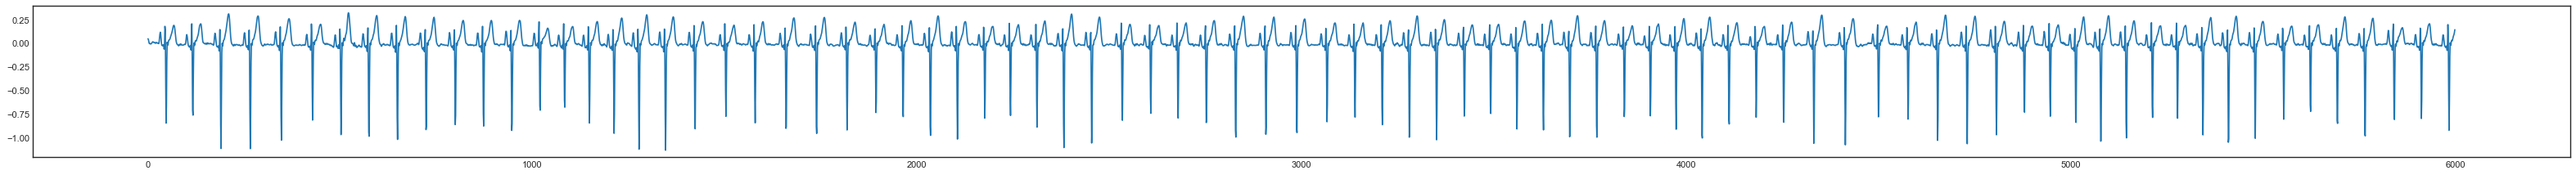

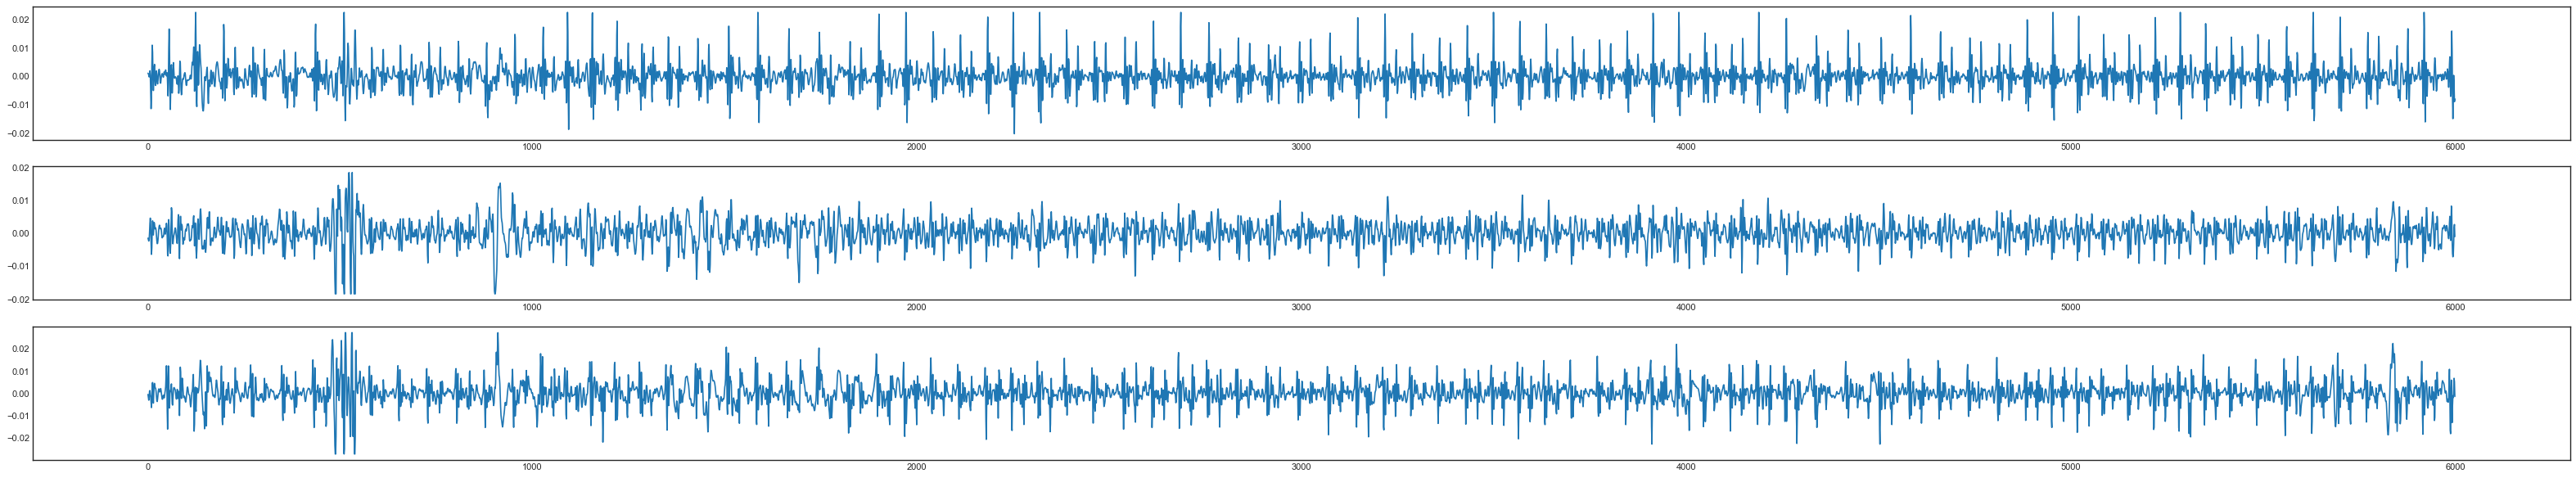

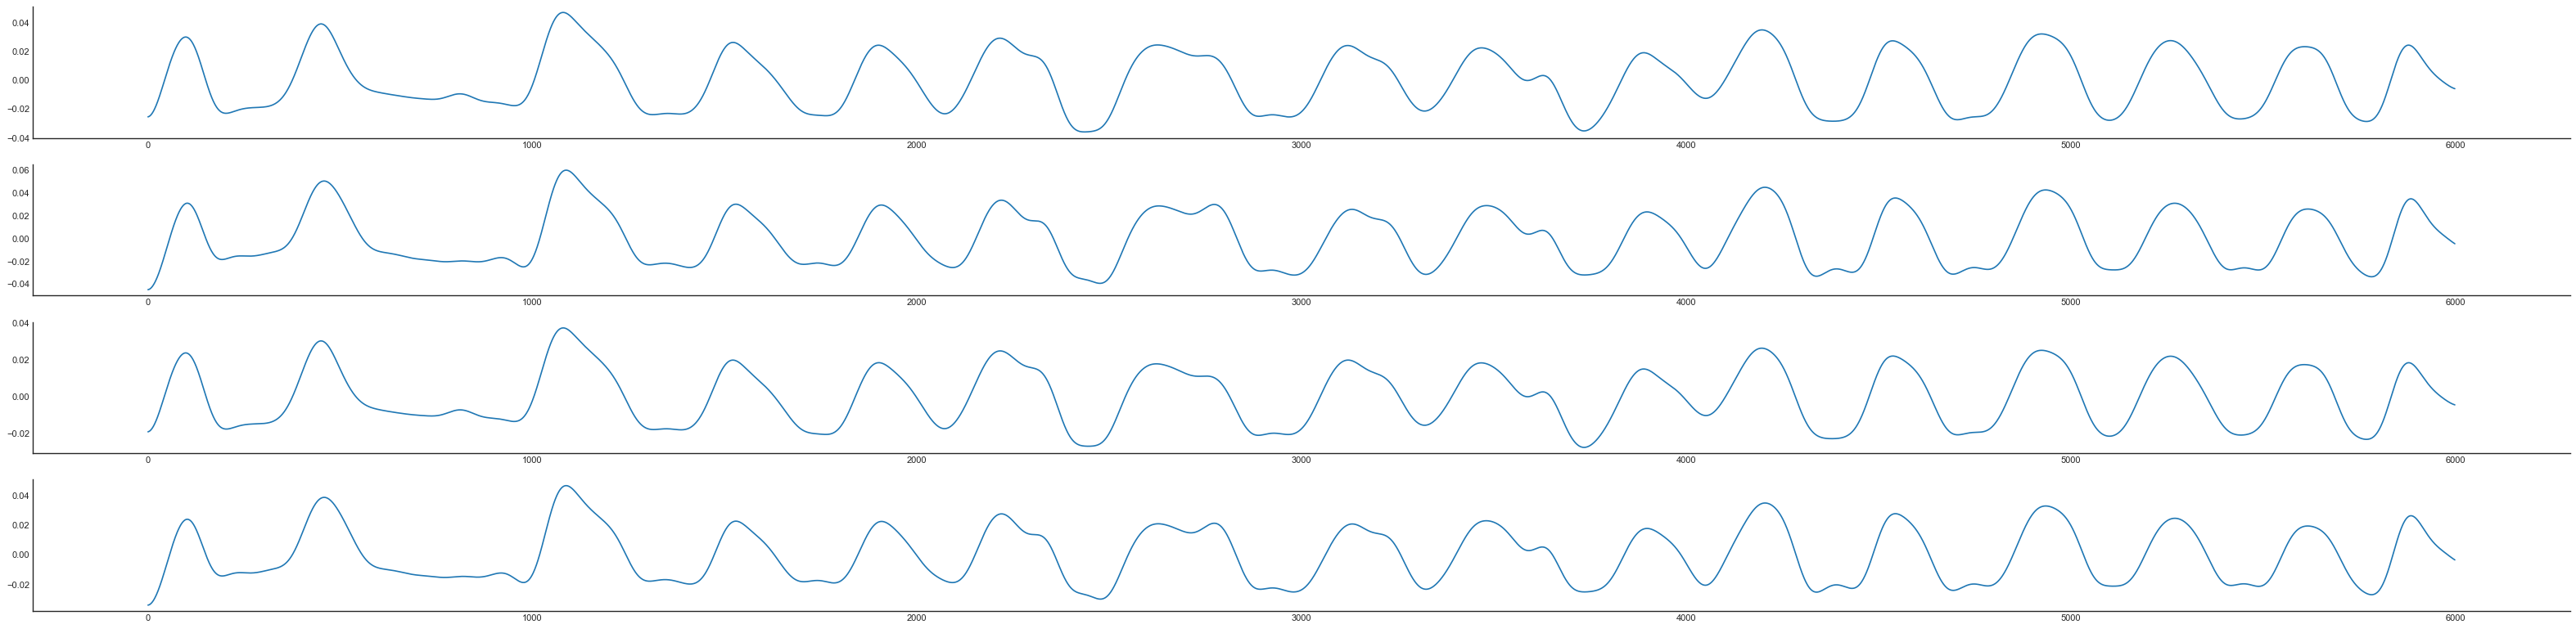

In [10]:
with open(training_params_file) as json_file:
    training_params_list = json.load(json_file)

for training_params in [training_params_list[0]]:
    # include device in training_params
    
    if training_params['cuda_i']==-1:
        device = torch.device('cpu')
    else:
        device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')
    training_params['device'] = device
    
    if 'training_mode' in training_params:
        training_mode = training_params['training_mode']
    else:
        training_params = 'subject_ind'

    task_id = [0, 1, 2, 3, 4, 5]
    # task_id = [0]
    # task_id = [1, 2]

    training_params['CV_config'] = {
        'subject_id': 113,
        'task_ids': task_id,
        # 'reject_subject_id': [101, 102, 103, 104, 105, 109]
        'reject_subject_id': [101, 102, 103, 109]
        # 'reject_subject_id': [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,112,114, 115]

        # 'task_id': 5,
    }
    
    training_params['ordered_subject_ids'] = [105, 115, 107, 117, 106, 104, 113, 114, 116,  119, 108, 110, 111, 118, 120, 121, 212]
    # training_params['ordered_subject_ids'] = [107, 117, 106]
    
    training_params['output_names'] = training_params['main_task'] + training_params['auxillary_tasks']
    
    
    # sys.exit()
    
    training_params['regression_names'] = get_regression_names(training_params)

    stage3_dict = data_loader('stage3_dict', inputdir).item()
    training_params['list_signal'] = stage3_dict['list_signal']
    training_params['list_feature'] = stage3_dict['list_feature']
    training_params['list_output'] = stage3_dict['list_output']
    training_params['list_meta'] = stage3_dict['list_meta']
    training_params['FS_RESAMPLE_DL'] = stage3_dict['FS_RESAMPLE_DL']
    training_params['subject_ids'] = stage3_dict['subject_ids']
    training_params['task_ids'] = stage3_dict['task_ids']
    training_params['sequence'] = stage3_dict['sequence']
    
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)
    print('ecg dimensions are:', dataloaders['train'].dataset.ecg.shape)
    print('scg dimensions are:', dataloaders['train'].dataset.scg.shape)
    print('ppg dimensions are:', dataloaders['train'].dataset.ppg.shape)
    print('feature dimensions are:', dataloaders['train'].dataset.feature.shape)
    print('label dimensions are:', dataloaders['train'].dataset.label.shape)
    print('meta dimensions are:', dataloaders['train'].dataset.meta.shape)

    ecg_dimensions = dataloaders['train'].dataset.__getitem__(0)[0].size()
    training_params['ecg_dimensions'] = list(ecg_dimensions)
    scg_dimensions = dataloaders['train'].dataset.__getitem__(0)[1].size()
    training_params['scg_dimensions'] = list(scg_dimensions)
    ppg_dimensions = dataloaders['train'].dataset.__getitem__(0)[2].size()
    training_params['ppg_dimensions'] = list(ppg_dimensions)

    training_params['data_dimensions'] = training_params['ecg_dimensions']
    
    
    inspect_signals(training_params, dataloaders)

    
    sweep_name = training_params['sweep_name'] 
    
    if training_params['model_name'] == 'FeatureExtractor_CNN':
        training_params['featrue_extractor'] = FeatureExtractor_CNN
    elif training_params['model_name'] == 'ResNet1D':
        training_params['featrue_extractor'] = ResNet1D
    elif training_params['model_name'] == 'FeatureExtractor_CNN2':
        training_params['featrue_extractor'] = FeatureExtractor_CNN2
    elif 'CNNlight' in training_params['model_name']: # designed for HR estimation
        training_params['feature_extractor'] = FeatureExtractor_CNNlight


    # get the right regressor
    if training_params['regressor_type'] == 'DominantFreqRegression':
        training_params['regressor'] = DominantFreqRegression
    elif training_params['regressor_type'] == 'FFTRegression':
        training_params['regressor'] = FFTRegression
    elif training_params['regressor_type'] == 'CardioRespRegression':
        training_params['regressor'] = CardioRespRegression       
    elif training_params['regressor_type'] == 'vanilla_regression':
        training_params['regressor'] = vanilla_regression
    elif training_params['regressor_type'] == 'CardioRespXGBRegression':
        training_params['regressor'] = CardioRespRegression   
    


    if training_params['auxillary_regressor_type'] == 'DominantFreqRegression':
        training_params['auxillary_regressor'] = DominantFreqRegression

    # order subject so we can see the worst subjects first
    if 'ordered_subject_ids' in training_params:
        training_params['ordered_subject_ids'] = np.asarray(training_params['ordered_subject_ids'])
    else:
        training_params['ordered_subject_ids'] = training_params['subject_ids']
    
    training_params['inputdir'] = inputdir
    training_params['outputdir'] = outputdir
    
    # training_params['regression_names'] = get_regression_names(training_params)

    if 'LSTM' in training_params['model_name']:
        training_params = change_output_dim(training_params)

    training_params['HR_xf_dict'] = update_freq_meta(training_params, 'HR', n_block=3)
    training_params['RR_xf_dict'] = update_freq_meta(training_params, 'RR', n_block=4)

    del dataloaders
    torch.cuda.empty_cache()
# training_params = training_params_list[0]

In [11]:
# update_freq_meta(training_params, 'RR', n_block=4)

In [12]:
# dataloaders, dataset_sizes = get_loaders(inputdir, training_params)


# define trainer, evaler, preder functions

In [13]:
trainer = train_mtlnet
evaler = eval_mtlnet
preder = pred_mtlnet

# test the model

# TODO: need to fix summary()

In [14]:
def ma_test(training_params):
    print('using model ', training_params['model_name'])

    device = training_params['device']
    # prepare model
    model = cardioresp_multiverse(training_params=training_params)
    model = model.to(device).float()

    # prepare data
    dataloaders, dataset_sizes = get_loaders(inputdir, training_params)

    ecg = dataloaders['val'].dataset.ecg[:5,:,:]
    ecg = torch.from_numpy(ecg)
    scg = dataloaders['val'].dataset.scg[:5,:,:]
    scg = torch.from_numpy(scg)
    ppg = dataloaders['val'].dataset.ppg[:5,:,:]
    ppg = torch.from_numpy(ppg)

    feature = dataloaders['val'].dataset.feature[:5,:]
    feature = torch.from_numpy(feature)

    label = dataloaders['val'].dataset.label[:5,:]
    label = torch.from_numpy(label)

    ecg = ecg.to(device=device, dtype=torch.float)
    scg = scg.to(device=device, dtype=torch.float)
    ppg = ppg.to(device=device, dtype=torch.float)
    feature = feature.to(device=device, dtype=torch.float)
    label = label.to(device=device, dtype=torch.float)

    # model inference
    # output, deep_feature, concat_feature = model(ecg, scg, ppg, feature)
    out, deep_feature, concat_feature, attention_dict = model(ecg, scg, ppg, feature)

    print('out')
    for key in out:
        print(key, out[key].size())

    print('deep_feature')
    for key in deep_feature:
        print(key, deep_feature[key].size())
        
    print('concat_feature', concat_feature.size())

    # print(concat_feature.size())
    # print(label.size())

    # compute loss
    criterion = MultiTaskLoss(training_params)
    losses = criterion(out, label)

    # check losses
    # print(losses)
    # print(model)


In [15]:
# training_params['regression_names']

In [16]:
def test_model(training_params):

    print('using model ', training_params['model_name'])
    training_params_copy = copy.deepcopy(training_params)
    training_params_copy['device'] = torch.device('cpu')

    model = cardioresp_multiverse(training_params=training_params_copy)
    summary(model, input_size=[tuple(training_params['ecg_dimensions']),tuple(training_params['scg_dimensions']),tuple(training_params['ppg_dimensions']), (model.N_features,1)], device='cpu')
    print(model)
    del model


debug_model = True
if debug_model==True:
    # if 'LSTM' not in training_params['model_name']:
    #     test_model(training_params)
    # else:
    ma_test(training_params)


using model  CNNlight
feature_out_dim   : 750
feature_out_dim   : 750
feature_out_dim   : 375
feature_out_dim   : 375
cuda:0
cuda:0
pytorch_total_params 62447
out
merged-HR_patch torch.Size([5, 1])
merged-RR_cosmed torch.Size([5, 1])
VO2_cosmed torch.Size([5, 1])
deep_feature
ECG-HR_patch torch.Size([5, 8, 750])
SCG-HR_patch torch.Size([5, 8, 750])
PPG-RR_cosmed torch.Size([5, 8, 375])
SCG-RR_cosmed torch.Size([5, 8, 375])
concat_feature torch.Size([5, 25])


# define training, validating, and evaluating funcitons 

## train, val, eval model

In [17]:
if training_params['wandb']:
    os.environ["WANDB_DIR"] = os.path.abspath(outputdir)
    os.environ["WANDB_NOTEBOOK_NAME"] = 'DL_regression'
    wandb.login()


In [18]:
def get_sweep_folder(training_params):
    n_block = training_params['n_block']
    inputs_combined = '+'.join([ i_name.split('_')[0] for i_name in training_params['input_names']])
    # main_weight = training_params['loss_weights']['main_task']
    # auxillary_weight = training_params['loss_weights']['auxillary_task']
    main_weight = training_params['main_loss_weight']
    auxillary_weight = training_params['auxillary_loss_weight']
    
    
    
    channel_n = training_params['channel_n']
    
    auxillary_task = training_params['auxillary_tasks'][0]

    # sweep_folder = '{}blocks-{}-weight{}+{}-{}ch-act{}-{}'.format(n_block, inputs_combined, auxillary_weight, adversarial_weight, channel_n, list_act, training_params['regressor_type'])
    # sweep_folder = '{}blocks-{}-weight{}+{}-{}'.format(n_block, inputs_combined, main_weight, auxillary_weight, auxillary_task)
    sweep_folder = '{}-weight{}-{}-hidden{}-{}'.format(inputs_combined, main_weight, auxillary_weight, training_params['hidden_dim'], auxillary_task)

    return sweep_folder


In [19]:
def get_outputdirs(training_params):

    outputdir = training_params['outputdir']
    sweep_folder = get_sweep_folder(training_params)
    outputdir_sweep = outputdir+'{}/'.format(sweep_folder)

    outputdir_numeric = outputdir_sweep + 'numeric_results/'
    if outputdir_numeric is not None:
        if not os.path.exists(outputdir_numeric):
            os.makedirs(outputdir_numeric)

    outputdir_modelout = outputdir_sweep + 'model_output/'
    if outputdir_modelout is not None:
        if not os.path.exists(outputdir_modelout):
            os.makedirs(outputdir_modelout)
            
    outputdir_activation = outputdir_sweep + 'activation_layers/'
    if outputdir_activation is not None:
        if not os.path.exists(outputdir_activation):
            os.makedirs(outputdir_activation)
            
    outputdir_attention = outputdir_sweep + 'attention_diag/'
    if outputdir_attention is not None:
        if not os.path.exists(outputdir_attention):
            os.makedirs(outputdir_attention)
            
    outputdir_featureimportance = outputdir_sweep + 'feature_importance/'
    if outputdir_modelout is not None:
        if not os.path.exists(outputdir_featureimportance):
            os.makedirs(outputdir_featureimportance)

    training_params['outputdir_sweep'] = outputdir_sweep
    training_params['outputdir_numeric'] = outputdir_numeric
    training_params['outputdir_modelout'] = outputdir_modelout
    training_params['outputdir_activation'] = outputdir_activation
    training_params['outputdir_attention'] = outputdir_attention
    training_params['outputdir_featureimportance'] = outputdir_featureimportance
    # training_params['outputdir_feature'] = outputdir_feature

    return training_params

In [20]:
# training_params['CV_config']['subject_id'] = 108

In [21]:
# training_params['outputdir_attention']

In [22]:
# plt.plot(training_params['HR_xf_dict']['xf_masked'], attention_dicts['fused_fft_HR'][i_sample,0,:], '.-', color='gray', alpha=0.8)


In [23]:
# training_params['adaptive_loss_name']=='awl'

In [24]:
# criterion = MultiTaskLoss(training_params)
# loss_weights_dict  = 

In [25]:
# aaa = {'merged-HR_patch2': 1.0, 'merged-RR_cosmed2': 1.0, 'VO2_cosmed2': 1.0}

In [26]:
# bbb = merge_dict(loss_weights_dict, aaa)
# bbb

In [27]:
# awl = AutomaticWeightedLoss(len(self.criterions.keys()))


In [28]:
debug_auxillary = False

def train_master(training_params):
    
    training_params['regression_names'] = get_regression_names(training_params)
    training_params = get_outputdirs(training_params) # could be tricky since it changes several keys
    # training_params['xf_dict'] = update_freq_meta(training_params)

    pprint.pprint(training_params)
    

    criterion = MultiTaskLoss(training_params)
    output_names = list(criterion.criterions.keys())
    
    df_performance_train = {}
    df_performance_val = {}

    df_outputlabel_train = {}
    df_outputlabel_val = {}

    for task in output_names:

        df_performance_train[task] = pd.DataFrame()
        df_performance_val[task] = pd.DataFrame()

        df_outputlabel_train[task] = pd.DataFrame()
        df_outputlabel_val[task] = pd.DataFrame()


    ordered_subject_ids = training_params['ordered_subject_ids']
    # main_task = training_params['output_names'][0].split('-')[0]
    main_task = training_params['main_task'][0] # VO2_cosmed

    # for subject_id in training_params['subject_ids']:
    for i_CV, subject_id in enumerate(ordered_subject_ids):
        
        if 'CV_max' in training_params:
            if i_CV >= training_params['CV_max']:
                continue
                
        if subject_id in training_params['CV_config']['reject_subject_id']:
            continue

        training_params['CV_config']['subject_id'] = subject_id

        # device = torch.device('cuda:{}'.format(int(training_params['cuda_i'])) if torch.cuda.is_available() else 'cpu')
        print('using device', training_params['device'])
        print('using model ', training_params['model_name'])
        print('subject id:', subject_id)

#         training_params = get_regressor_names(training_params)
        model = cardioresp_multiverse(training_params=training_params)
#         print(model)
        
        model = model.to(device).float()
        criterion = criterion.to(device).float()
        # print('model created')


        if training_params['regressor_type']=='CardioRespXGBRegression':
            training_params['xgb_regressor'] = XGBRegressor(learning_rate=0.05, max_depth=50, subsample=0.6, colsample_bytree=0.7, n_estimators=100, min_child_weight=2, gamma=0.001, verbosity=0)

        
        if training_params['adaptive_loss_name']=='awl':
            optimizer = torch.optim.Adam([
                    {'params': model.parameters(), 'lr':training_params['learning_rate'], 'weight_decay': 0.1},
                    {'params': criterion.parameters(), 'lr':training_params['learning_rate'], 'weight_decay': 0.1},
                    # {'params': criterion.parameters(), 'weight_decay': 0}
                ])
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=0.1)

        
        # if training_params['optimizer_name'] == 'Adam':
        #     optimizer = torch.optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=0.1)
        # # optimizer = torch.optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=0.9)
        # elif training_params['optimizer_name'] == 'LBFGS':
        #     optimizer =  torch.optim.LBFGS(model.parameters(), history_size=10, max_iter=4)


        training_params['criterion'] = criterion
        training_params['optimizer'] = optimizer
        training_params['inputdir'] = inputdir
        


        CV_dict = train_model(model, training_params, trainer, evaler, preder)

        
        # print(CV_dict['performance_dict_val']['concat_feature_arr'].shape)
        # sys.exit()

        for task in output_names:
            task_name = task.split('-')[-1].split('_')[0]


#         for task in training_params['tasks']:

#             print( CV_dict['performance_dict_val']['out_dict'].keys(), CV_dict['performance_dict_val']['label_dict'].keys(), task)
            label_est_val = CV_dict['performance_dict_val']['out_dict'][task]
            label_val = CV_dict['performance_dict_val']['label_dict'][task]

            label_est_train = CV_dict['performance_dict_train']['out_dict'][task]
            label_train = CV_dict['performance_dict_train']['label_dict'][task]
            
            # activity_train = CV_dict['performance_dict_train']['meta_arr'][:,1]
            # activity_val = CV_dict['performance_dict_val']['meta_arr'][:,1]
            
            
            # get performance df for training and testing dataset
            df_performance_train[task] = df_performance_train[task].append( get_df_performance(label_train, label_est_train, subject_id, task), ignore_index=True )

            df_performance_train[task].to_csv(training_params['outputdir_numeric'] + 'df_performance_train_{}.csv'.format(task), index=False)

            df_outputlabel_train[task] = df_outputlabel_train[task].append(
                pd.DataFrame( {
                    'label_est': label_est_train,
                    'label': label_train,
                    'CV': [subject_id]*label_train.shape[0],
                    'task': [task]*label_train.shape[0],
                    'activity': CV_dict['performance_dict_train']['meta_arr'][:,1],
                    'weight': CV_dict['performance_dict_train']['feature_arr'][:,0],
                    'height': CV_dict['performance_dict_train']['feature_arr'][:,1],
                }), ignore_index=True )

            df_outputlabel_train[task].to_csv(training_params['outputdir_numeric'] + 'df_outputlabel_train_{}.csv'.format(task), index=False)

            df_performance_val[task] = df_performance_val[task].append( get_df_performance(label_val, label_est_val, subject_id, task), ignore_index=True )
            df_performance_val[task].to_csv(training_params['outputdir_numeric'] + 'df_performance_val_{}.csv'.format(task), index=False)

            df_outputlabel_val[task] = df_outputlabel_val[task].append(
                pd.DataFrame( {
                    'label_est': label_est_val,
                    'label': label_val,
                    'CV': [subject_id]*label_val.shape[0],
                    'task': [task]*label_val.shape[0],
                    'activity': CV_dict['performance_dict_val']['meta_arr'][:,1],
                    'weight': CV_dict['performance_dict_val']['feature_arr'][:,0],
                    'height': CV_dict['performance_dict_val']['feature_arr'][:,1],
                }), ignore_index=True )

            df_outputlabel_val[task].to_csv(training_params['outputdir_numeric'] + 'df_outputlabel_val_{}.csv'.format(task), index=False)

            # plot performance training and testing dataset
            # if (main_task not in task) and (debug_auxillary==False):
            #     continue
            
            if training_params['show_plot']:
                plot_regression(df_outputlabel_val[task],  training_params, task_name=task_name, fig_name='regression_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])

            #     continue
#             plot_regression(df_outputlabel_train[task], training_params, task_name=task_name, fig_name='regression_train_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
#             plot_regression(df_outputlabel_val[task],  training_params, task_name=task_name, fig_name='regression_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
# #             plot_BA(df_outputlabel_train[task], task, fig_name='BA_train_{}'.format(task), show_plot=False, outputdir=outputdir+'model_output/')
#             plot_output(df_outputlabel_val[task],  task_name=task_name, fig_name = 'outputINtime_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'])
        
        # check_featuremap(model, training_params, mode='worst', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=outputdir+'activation_layers_worst/{}/'.format(subject_id), show_plot=False)
        # check_featuremap(model, training_params, mode='best', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=outputdir+'activation_layers_best/{}/'.format(subject_id), show_plot=False)


        if training_params['show_plot']:
            # continue
            
            plot_losses(CV_dict, outputdir=training_params['outputdir_sweep'], show_plot=False, fig_name='loss_{}'.format(subject_id))

            if 'CNNlight' in training_params['model_name']:
                print('check_featuremap ...')
                check_featuremap(model, training_params, mode='worst', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=training_params['outputdir_activation']+'worst/{}/'.format(subject_id), show_plot=False)
                check_featuremap(model, training_params, mode='best', fig_name = 'DL_activation_{}_'.format(subject_id), outputdir=training_params['outputdir_activation']+'best/{}/'.format(subject_id), show_plot=False)

                check_attention(CV_dict, task, training_params, mode='best', fig_name='attention_{}_{}'.format(subject_id, task_name), outputdir=training_params['outputdir_attention']+'best/', show_plot=False)
                check_attention(CV_dict, task, training_params, mode='worst', fig_name='attention_{}_{}'.format(subject_id, task_name), outputdir=training_params['outputdir_attention']+'worst/', show_plot=False)


            if 'xgb_regressor' in training_params:
                xgb_feature_names = np.r_[np.arange(model.extracted_dim), np.asarray(training_params['feature_names'])]

                # print(xgb_feature_names, xgb_feature_names.shape)
                # print(training_params['xgb_regressor'].feature_importances_, training_params['xgb_regressor'].feature_importances_.shape)

                plot_feature_importances(xgb_feature_names, training_params['xgb_regressor'].feature_importances_, fig_name='feature_importance_'+str(subject_id), outputdir=training_params['outputdir_featureimportance'], show_plot=False, log_wandb=training_params['wandb'])


        
        
        del model
        torch.cuda.empty_cache()


    # for task in training_params['regression_names']:
    for task in output_names:

        # if task!=main_task:
        # if main_task in task:
        #     continue
        if not training_params['show_plot']:
            continue
            
        task_name = task.split('-')[-1].split('_')[0]


        plot_regression(df_outputlabel_train[task], training_params, task_name=task_name, fig_name='regression_train_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
        plot_regression(df_outputlabel_val[task],  training_params, task_name=task_name, fig_name='regression_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
#             plot_BA(df_outputlabel_train[task], task, fig_name='BA_train_{}'.format(task), show_plot=False, outputdir=outputdir+'model_output/')
        # plot_output(df_outputlabel_val[task],  task_name=task_name, fig_name = 'outputINtime_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'])
        
        # plot_regression_all_agg(df_outputlabel_train[task], training_params, task_name=task_name, fig_name='LinearR_agg_train_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
        # plot_BA(df_outputlabel_train[task],  training_params=training_params, task_name=task_name, fig_name='BA_train_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])

        # plot_regression_all_agg(df_outputlabel_val[task], training_params, task_name=task_name, fig_name='LinearR_agg_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])
        # plot_BA(df_outputlabel_val[task],  training_params=training_params, task_name=task_name, fig_name='BA_val_{}'.format(task), show_plot=False, outputdir=training_params['outputdir_modelout'], log_wandb=training_params['wandb'])

        plot_output(df_outputlabel_val[task],  task_name=task_name, fig_name = 'outputINtime_val_{}'.format(task),  show_plot=False, outputdir=training_params['outputdir_modelout'])

    # plot_BA(df_outputlabel_val[main_task], main_task, fig_name='BA_val_{}'.format(main_task), show_plot=False, outputdir=outputdir+'model_output/', log_wandb=training_params['wandb'])
    # plot_regression_all_agg(df_outputlabel_val[main_task], df_performance_val[main_task], outputdir=outputdir+'model_output/', show_plot=False, log_wandb=training_params['wandb'])

    # log metrices on wnadb
    if training_params['wandb']==True:
        task = training_params['regression_names'][-1]
        # W&B
        label = df_outputlabel_val[task]['label'].values
        label_est = df_outputlabel_val[task]['label_est'].values
#         print(label.shape, label)
#         print(label_est.shape, label_est)
    
        PCC = get_PCC(label, label_est)
        Rsquared = get_CoeffDeterm(label, label_est)
        MAE, _ = get_MAE(label, label_est)
        RMSE = get_RMSE(label, label_est)
        MAPE, _ = get_MAPE(label, label_est)

        wandb.log(
            {
                'val_MAE': MAE,
                'val_RMSE': RMSE,
                'val_MAPE': MAPE,
                'val_PCC': PCC,
                'val_Rsquared': Rsquared,
            })

In [29]:
# training_params['loss_weights']

In [30]:
# feature_names = np.arange(100)

# fig, ax = plt.subplots(1,1, figsize=(5, 50), dpi=100)
# fontsize = 12
# ax.barh(feature_names, feature_names)
# ax.tick_params(axis='both', labelsize=fontsize)

In [31]:
# plot_output

In [32]:
# # import sys

# def exc_handler(exc_type, exc, tb):
#     print("EXCEPTION")
#     traceback.print_exception(exc_type, exc, tb)

# sys.excepthook = exc_handler

In [33]:
import traceback

def train_sweep(config=None):   
#     with wandb.init(config=config, entity='inanlab', project="[TL] stage2_cnn", reinit=True, dir=outputdir):
    with wandb.init(config=config, reinit=True, dir=outputdir):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        print(config)
                
        for key in config.keys():
            training_params[key] = config[key]
            
            
        try: 
            train_master(training_params)
        except Exception:
            print(traceback.print_exc(), file=sys.stderr)

# TODO: use training_params['regressor_names'] for looping

In [ ]:
if training_params['wandb']:
    print('sweeping for:', sweep_name)
    sweep_config = training_params['sweep_config']    
#     with wandb.init(config=config, entity='inanlab', project="[TL] stage2_cnn", reinit=True, dir=outputdir):
    sweep_id = wandb.sweep(sweep_config, entity='inanlab', project='[VO2] stage4_'+training_params['sweep_name'])

    wandb.agent(sweep_id, train_sweep)

else:
    train_master(training_params)


{'CR_attention': True,
 'CV_config': {'reject_subject_id': [101, 102, 103, 109],
               'subject_id': 113,
               'task_ids': [0, 1, 2, 3, 4, 5]},
 'FS_RESAMPLE_DL': 100,
 'HR_xf_dict': {'FS_Extracted': 12.5,
                'freq_range': [40, 190],
                'last_layer_dim': 750,
                'mask': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,

In [ ]:
sys.exit()

In [36]:
import umap


ModuleNotFoundError: No module named 'umap'

In [ ]:
features  = np.random.rand(125, 25)

In [ ]:
features = StandardScaler().fit_transform(features) # normalizing the features
print('show standardize mean and std:', np.mean(features),np.std(features))

reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

df_embedding = {
    'UMAP0': embedding[:, 0],
    'UMAP1': embedding[:, 1],
}

In [ ]:
metric = 'bias'

dim1_name = 'UMAP0'
dim2_name = 'UMAP0'

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=120)

ax.set_xlabel(dim1_name,fontsize=12)
ax.set_ylabel(dim2_name,fontsize=12)
# ax.set_title('{}\n(explained_var: {:.2f}%)'.format(feature_names, explained_var),fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)


# race_color_dict = {
#     'Caucasian or White': 'firebrick',
#     'African American  or Black': 'steelblue',
# }





# pt_label = ['']

marker = 'o'
# colors = 'r'
alpha = 0.3
fontsize = 15

# mask_White = df_demographic_processed['White']==True
# mask_Black = df_demographic_processed['Black']==True

markers = {"Caucasian or White": "o", "African American  or Black": "X"}
# sns.scatterplot(data=tips, x="total_bill", y="tip", style="time", markers=markers)



# g = sns.scatterplot(data=df_embedding, x=dim1_name, y=dim2_name, hue=metric, style="Race String", ax=ax, palette='viridis', markers=markers,alpha=alpha)
# sns.rugplot(data=df_embedding, x=dim1_name, y=dim2_name, hue=metric, ax=ax)
# g.legend_.remove()


# # title_str = '[{}]\n{} range: {:.1f}-{:.1f} {}'.format(subject_id, task.split('_')[0], label_range_sub[0], label_range_sub[1], unit_dict[task_name])

# textstr = get_regression_stats(df_demographic_processed, verbose=False)
# props = dict(boxstyle='round,pad=0.7', facecolor='white', edgecolor='black', alpha=0.7)

# # place a text box in bottom right in axes coords
# ax.text(0.6, 0.77, textstr, transform=ax.transAxes, fontsize=fontsize-5,
#         verticalalignment='bottom', horizontalalignment='left', bbox=props)


# #Colormap for comparison
# cmap = plt.get_cmap("viridis")
# norm = plt.Normalize(df_demographic_processed[metric].min(), df_demographic_processed[metric].max())
# sm =  ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=ax)



# # handles, labels  =  ax.get_legend_handles_labels()
# # ax.legend(handles=handles[-3:], labels=labels[-3:])
# # ax.legend(bbox_to_anchor= (.01, 1.05), prop={'size': fontsize-5})

# ax_no_top_right(ax)
# plt.show()

In [ ]:
fontsize = 20

j_handle = sns.jointplot(
    data=df_demographic_processed,
    x=dim1_name, y=dim2_name, hue='Race String',
    palette=race_color_dict,
    shade=True, shade_lowest=False, 
    alpha=0.5,
    kind="kde",
    
    height=7,
    marginal_ticks=True
)

# JointGrid has a convenience function
j_handle.set_axis_labels(dim1_name, dim2_name, fontsize=fontsize)

In [ ]:
sys.exit()

In [ ]:
# training_params['regression_names']

In [ ]:
# xf, yf = get_psd(aaa, training_params['FS_Extracted'])
# mask = training_params['xf_dict']['mask']
# xf, yf = xf[mask], yf[mask]

# yf = yf / np.sum(yf)

# plt.plot(xf, yf, color='r')


# yf = get_smooth(yf, N=5)
# yf = yf / np.sum(yf)

# plt.plot(xf, yf, color='g')
# thre = np.mean(yf)
# yf = yf > thre

# plt.axhline(y=thre, color = 'black', linestyle = '-')



# #         # attention dim: (N_batch, 1, N_spectral)
# #         attention = attention / torch.sum(attention, axis=-1)[:,None]
        
# #         attention = attention > torch.mean(attention, axis=-1, keepdim=True)
        
# plt.plot(xf, yf*0.1, color='b')


In [ ]:
xf, yf = get_psd(aaa, training_params['FS_Extracted'])
mask = training_params['xf_dict']['mask']
xf, yf = xf[mask], yf[mask]

yf = yf / np.sum(yf)

plt.plot(xf, yf, color='r')


freq_smooth_dur = 5/60 # Hz
freq_smooth_win = round(freq_smooth_dur / np.mean(np.diff(xf)))
m = MyAvgPool1dPadSame(kernel_size=freq_smooth_win, stride=1)
yf = m(torch.tensor(yf)[None,None,:]).data.numpy().squeeze()
yf = yf / np.sum(yf)

plt.plot(xf, yf, color='g')

thre = np.mean(yf)
yf = yf > thre

plt.axhline(y=thre, color = 'black', linestyle = '-')



#         # attention dim: (N_batch, 1, N_spectral)
#         attention = attention / torch.sum(attention, axis=-1)[:,None]
        
#         attention = attention > torch.mean(attention, axis=-1, keepdim=True)
        
plt.plot(xf, yf*0.1, color='b')


In [ ]:
# np.diff(xf).mean()*5*60

In [ ]:
wandb.finish()

In [ ]:

datetime_end = datetime.now(tz_NY)
print("end time:", datetime_end.strftime("%Y-%b-%d %H:%M:%S"))

duration = datetime_end-datetime_start
duration_in_s = duration.total_seconds()
days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
print("Time between dates: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [ ]:
sys.exit()

In [ ]:
training_params['model_name']

In [ ]:
# # def get_activation(name):
# #     activation = {}
# #     def hook(model, input, output):
# #         activation[name] = output.detach()
# #     return hook
    
# def model_hooking(model, training_params, get_activation):

#     model_name = training_params['model_name']
    
#     if model_name=='FeatureExtractor_CNN2':
#         key = list(model.feature_extractors.keys())[0]
#         model.feature_extractors[key].layer1.register_forward_hook(get_activation('layer1'))
#         model.feature_extractors[key].layer2.register_forward_hook(get_activation('layer2'))
#         model.feature_extractors[key].layer3.register_forward_hook(get_activation('layer3'))
#         model.feature_extractors[key].layer4.register_forward_hook(get_activation('layer4'))
#         model.regressors.EE_cosmed.fc1.register_forward_hook(get_activation('fc1'))
#         model.regressors.EE_cosmed.fc2.register_forward_hook(get_activation('fc2'))
        
# #         layer_names = ['layer1', ]
        
#     elif model_name=='FeatureExtractor_CNN':
#         key = list(model.feature_extractors.keys())[0]
#         model.feature_extractors[key].layer1.register_forward_hook(get_activation('layer1'))
#         model.feature_extractors[key].layer2.register_forward_hook(get_activation('layer2'))
#         model.feature_extractors[key].layer3.register_forward_hook(get_activation('layer3'))
#         model.feature_extractors[key].layer4.register_forward_hook(get_activation('layer4'))
#         model.regressors.EE_cosmed.fc1.register_forward_hook(get_activation('fc1'))
#         model.regressors.EE_cosmed.fc2.register_forward_hook(get_activation('fc2'))
#     if model_name=='ResNet1D':
#         pass
# #         key = list(model.feature_extractors.keys())[0]
# #         model.feature_extractors[key].layer1.register_forward_hook(get_activation('layer1'))
# #         model.feature_extractors[key].layer2.register_forward_hook(get_activation('layer2'))
# #         model.feature_extractors[key].layer3.register_forward_hook(get_activation('layer3'))
# #         model.feature_extractors[key].layer4.register_forward_hook(get_activation('layer4'))
# #         model.regressors.EE_cosmed.fc1.register_forward_hook(get_activation('fc1'))
# #         model.regressors.EE_cosmed.fc2.register_forward_hook(get_activation('fc2'))


In [ ]:
# training_params['model_name']

# TODO: improve this block

In [ ]:
performance_dict_train = preder(model, dataloaders['train'], training_params)
performance_dict_val = preder(model, dataloaders['val'], training_params)

unit = unit_dict[task.split('_')[0]]

for task in training_params['tasks']:
    
    
    print('evaluating task:', task)
    MAE, std_AE = get_MAE(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task])
    print('\ttrainin: {:.2f}±{:.2f} {}'.format(MAE, std_AE, unit))

    MAE, std_AE = get_MAE(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task])
    print('\tval: {:.2f}±{:.2f} {}'.format(MAE, std_AE, unit))



# produce output figures
# TODO: implement the plotting functions below

# TODO!!!!

# for task in tasks
#     plot_loss vs epoch (train and val)
#     plot_MAE, RMSE, vs epoch (train and val)
#     plot scatter plots (show PCC, BD, std, ect.) (just val)
#     plot output vs. label (just val)

In [ ]:
output_name = training_params['output_names'][0].split('_')[0]
unit_dict[output_name]

In [ ]:
# kcalpmin2watt = 69.7333333

# sub_weight = 76

In [ ]:
# performance_dict_train['label_dict']

In [ ]:
training_params['tasks']

In [ ]:
for task in training_params['tasks']:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=100)
    fontsize = 15
    data_min = np.min(np.r_[performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task]])
    data_max = np.max(np.r_[performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task]])
    ax1.scatter(performance_dict_train['out_dict'][task], performance_dict_train['label_dict'][task], alpha=0.3)
    ax1.set_xlim(data_min, data_max)
    ax1.set_ylim(data_min, data_max)
    ax1.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

    ax1.set_xlabel('estimated {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    ax1.set_ylabel('true {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
#     ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
#     ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)

    ax1.set_title('training', fontsize=fontsize)


#     fig, ax = plt.subplots(figsize=(5,5))
#     fontsize = 15
    data_min = np.min(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
    data_max = np.max(np.r_[performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task]])
    ax2.scatter(performance_dict_val['out_dict'][task], performance_dict_val['label_dict'][task], alpha=0.3)
    ax2.set_xlim(data_min, data_max)
    ax2.set_ylim(data_min, data_max)
    ax2.plot( [data_min, data_max],[data_min, data_max], '--', color='gray', alpha=0.8)

    ax2.set_xlabel('estimated {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    ax2.set_ylabel('true {} ({})'.format(task.split('_')[0], unit_dict[task.split('_')[0]]), fontsize=fontsize)
    
    ax2.set_title('testing', fontsize=fontsize)

#     ax.set_xlabel('estimated {} ({})'.format(output_name, 'W'), fontsize=fontsize)
#     ax.set_ylabel('true {} ({})'.format(output_name, 'W'), fontsize=fontsize)
    plt.show()

